In [1]:
import librosa
import numpy as np
from IPython.display import Audio  #播放套件
import matplotlib.pyplot as plt 
import librosa.display  #libroso 繪圖
import time
import os, re
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
npzfile = np.load('df_zero_arr.npz')
print(npzfile.files)
X = npzfile['arr_0']
y = npzfile['arr_1']
print(X.shape, y.shape)

['arr_0', 'arr_1']
(36480, 128, 130) (36480,)


In [3]:
y_onehot = np.eye(10)[y]
y_onehot.shape

(36480, 10)

In [4]:
means = np.mean(X,axis=(0,2))
stds = np.std(X,axis=(0,2))
means = means.reshape(1,-1,1)
stds = stds.reshape(1,-1,1)
X = (X-means)/stds
X.shape

(36480, 128, 130)

In [5]:
X = X.reshape(36480, 128, 130, 1)
X.shape

(36480, 128, 130, 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
y_train.shape

(29184, 10)

In [7]:
batch_size = 32
num_classes = 10
epochs = 100
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'testmodel.h5'

In [14]:
# build our CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='valid',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
# model.add(Conv2D(128, (3, 3)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

model.add(Conv2D(32, (3, 3), padding='valid'))
model.add(Activation('relu'))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

# initiate Adam optimizer
opt = keras.optimizers.Adam()

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# earlystop
earlystop = EarlyStopping(monitor='val_accuracy', patience=13, verbose=1)

# Fit the model on the batches generated by datagen.flow().
# model_history = model.fit_generator(datagen.flow(x_train, y_train,
#                                  batch_size=batch_size),
#                     epochs=epochs,
#                     validation_data=(x_test, y_test),
#                     workers=4,
#                     callbacks=[earlystop])

model_history = model.fit(X_train, 
                          y_train,
                          batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    workers=1,
                    callbacks=[earlystop])

# loading our save model
# print("Loading trained model")
# model = load_model(model_path)

# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 128, 32)      320       
                                                                 
 activation_8 (Activation)   (None, 126, 128, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 62, 32)        9248      
                                                                 
 activation_9 (Activation)   (None, 61, 62, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 31, 32)       0         
 2D)                                                  

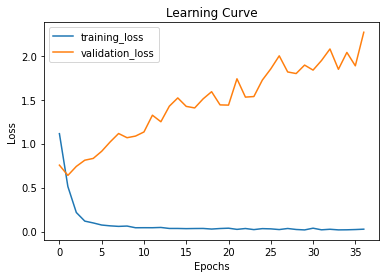

In [15]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

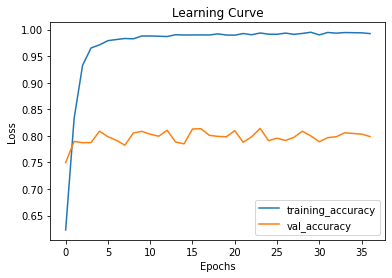

In [16]:
training_accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

plt.plot(training_accuracy, label="training_accuracy")
plt.plot(val_accuracy, label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
show_summary_stats(history)